In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1081 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 10*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [14]:
start_scope()
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
                method='ek4'
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(4000*ms)


BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/core/network.py", line 864, in before_run
    obj.before_run(run_namespace)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/groups/group.py", line 1106, in before_run
    self.update_abstract_code(run_namespace=run_namespace)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/groups/neurongroup.py", line 253, in update_abstract_code
    group_name=self.group.name)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/utils/caching.py", line 100, in cached_func
    func._cache[cache_key] = func(*args, **kwds)
  File "/home/alteska/Desktop/brian/brian2/build/lib.linux-x86_64-3.7/brian2/stateupdaters/base.py", line 218, in apply_stateupdater
    'is known' % method)
ValueError: No state updater with the name "ek4" is known

Error encountered with object named "neurongroup_stateupdater".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-14-7952726b2ff1>", line 5, in <module>
    method='ek4'

An error occurred when preparing an object. ValueError: No state updater with the name "ek4" is known
(See above for original error message and traceback.)

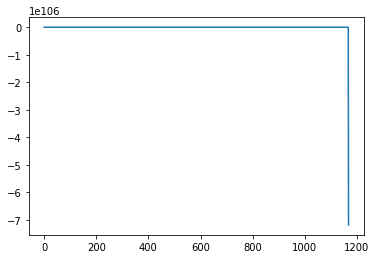

In [11]:
voltage1 = mon.v[0]/mV
plot(voltage1);

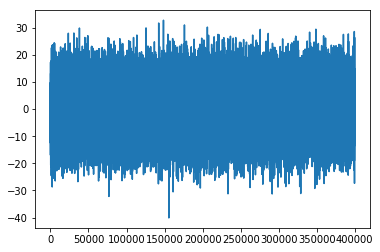

In [12]:
inp_cur1 = mon.I[0]/nA
plot(inp_cur1);

In [13]:
out_spikes1 = [spike_mon.spike_trains()[0]/ms]
out_spikes1

[array([ 3.23, 11.64])]

In [ ]:
start_scope()
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(40*second)

In [ ]:
voltage2 = mon.v[0]/mV
plot(voltage2);

In [ ]:
inp_cur2 = mon.I[0]/nA
plot(inp_cur2);

In [ ]:
out_spikes2 = [spike_mon.spike_trains()[0]/ms]
out_spikes2

In [ ]:
out_spikes1

In [ ]:
out_spikes = [out_spikes1[0], out_spikes2[0]]
out_spikes

In [ ]:
inp_current = [inp_cur1, inp_cur2]
inp_current

## Model Fitting

In [ ]:
eqs = Equations(
"""
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I*k - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
Vcut = VT + 50 * DeltaT : volt
taum = C / gL : second
gL: siemens (constant)
a : siemens (constant)
b : amp (constant)
VT : volt (constant)
DeltaT : volt (constant)
Vr : volt (constant)
k : 1 (constant)
C : farad (constant)
tauw : second (constant)
""", 
# EL : volt (constant)
# C: farad (constant)
# gL = 60 * nS,
# VT = -50.4 * mV,
# DeltaT = 5 * mV,    
# a = 4*nS,
# b = 0.0805*nA,
# Vr = -70.6*mV
# C = 171 * pF,
# tauw = 144*ms,
EL = -65 * mV,
)

In [ ]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=40*second, delta=4*ms)

In [ ]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=20,
                     threshold='v>Vcut',
                     reset="v=Vr; w+=b",
                     refractory=1.41*ms,
                     param_init={'v': -65*mV},
                     )

In [ ]:
result_dict, error = fitter.fit(n_rounds=10,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                gL=[30*nS, 60*nS],
                                a = [0, 20]*nS,
                                b = [0, 2]*nA,
                                VT = [-90, -10] * mV,
                                DeltaT = [5, 8] * mV,    
                                Vr = [-90, -30]*mV,
                                k = [0.01, 2],
                                C = [170, 200] * pF,
                                tauw = [0.1, 500]*ms,
                               )

In [ ]:
result_dict

In [ ]:
error

In [ ]:
1 - error

In [ ]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

In [ ]:
print(len(out_spikes[0]))
print(len(spikes[0]))

In [ ]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [ ]:
fits = fitter.generate(params=None, output_var='v',)

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))

ax[0].plot(voltage1);
ax[0].plot(fits[0]/mV)

ax[1].plot(voltage2);
ax[1].plot(fits[1]/mV);
